In [2]:
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [5]:
# df = pd.read_excel('IDD_To_Train.xlsx')
df = pd.read_csv('2019 Model Data - R0.csv')

In [6]:
df

,Month,Year,CityState,AffectedPop,Drs,NumReps,Revenue,VisitsEngaged
0,Mar,2018,AlbanyNY,85415.25,17,0,3424.5000,2
1,Apr,2018,AlbanyNY,109385.20,20,0,5932.5000,1
2,May,2018,AlbanyNY,138289.50,18,0,4483.0000,5
3,June,2018,AlbanyNY,138354.25,19,0,4780.5000,4
4,July,2018,AlbanyNY,108048.20,15,0,4554.5000,2
...,...,...,...,...,...,...,...,...
2470,Nov,2019,WilmingtonDE,31236.25,26,0,6113.0000,17
2471,Dec,2019,WilmingtonDE,26787.60,32,0,7933.0000,15
2472,Jan,2020,WilmingtonDE,29208.00,26,0,9044.0516,13
2473,Feb,2020,WilmingtonDE,27688.25,35,0,8691.0472,16


In [7]:
#Model some type of nonlinearity
df['drdr'] = df['Drs']*df['Drs']
df['log2dr'] = np.log2(df['Drs'])

/srv/conda/envs/notebook/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
#Fix any place where the log2 is -infinity (log of 0)
df.loc[df['log2dr']==-np.inf,'log2dr'] = 0

In [9]:
# train = df[['YrMth','CityState','AffectedPop','UV','NumReps','Staffed','Revenue','Calls','Tenure']]
# X = train[['YrMth','CityState','AffectedPop','UV','NumReps','Staffed','Calls','Tenure']]
# X_ols = train[['AffectedPop','UV','NumReps','Staffed']]
train = df[['Month','Year','CityState','AffectedPop','VisitsEngaged','NumReps','Drs','drdr','log2dr','Revenue']]
X = train[['Month','Year','CityState','AffectedPop','VisitsEngaged','NumReps','Drs','drdr','log2dr']]
X_ols = train[['AffectedPop','VisitsEngaged','NumReps','Drs','drdr','log2dr']]
y = train['Revenue']

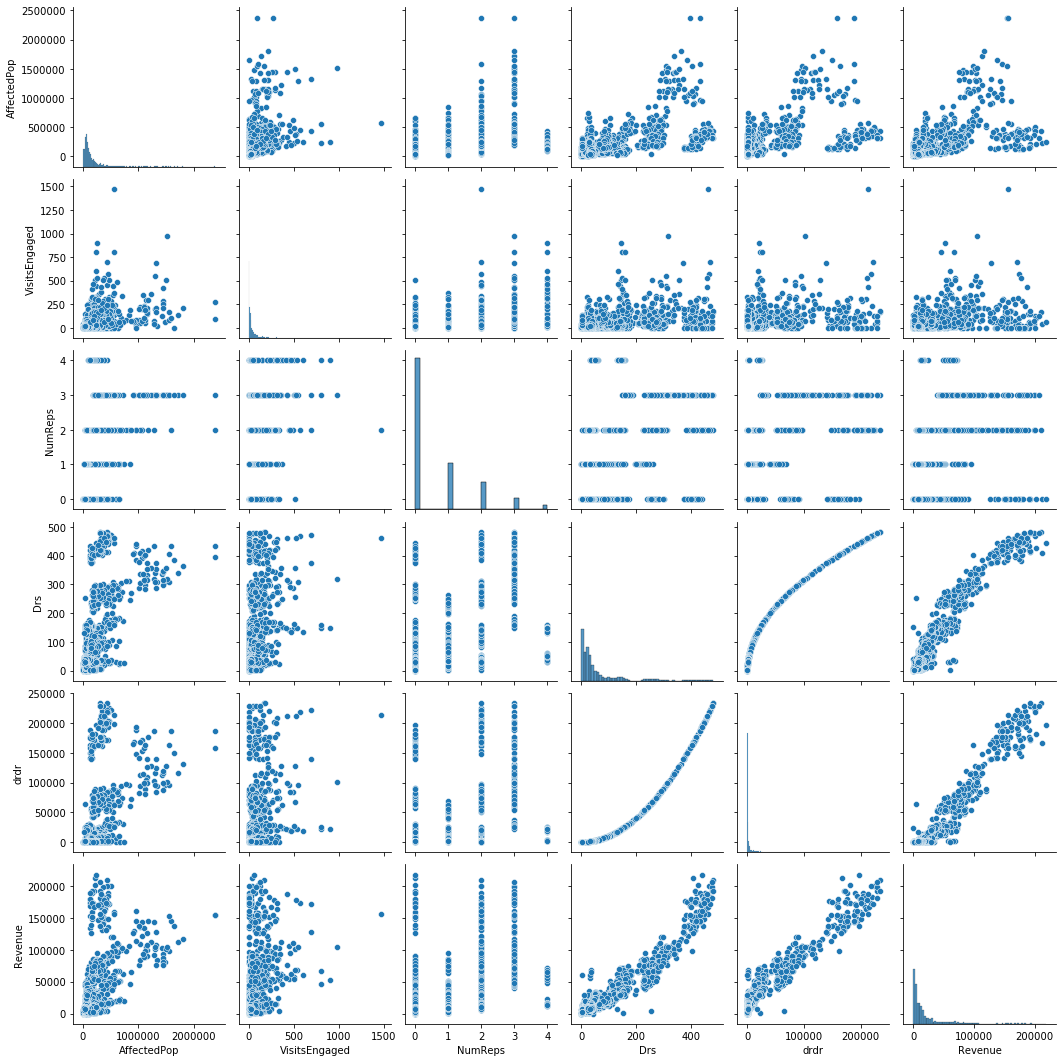

In [10]:
#Look at interactions between the variables. Not very many great relationships except definitely some interactions between # of Drs and Revenue
sns.pairplot(train[['AffectedPop','VisitsEngaged','NumReps','Drs','drdr','Revenue']])
plt.show()

In [11]:
#Split the data into train/test datasets and get ready to build a random forest

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

rf = RandomForestRegressor()
X = pd.get_dummies(X)

x_train, x_test, y_train, y_test = train_test_split(X,y)

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method

In [12]:
#Train an OLS regression on the original dataset (NOT INCLUDING dr squared or log dr created columns

train_test_cols = ['AffectedPop','VisitsEngaged','NumReps','Drs','drdr','log2dr']
x_train_all = sm.tools.add_constant(x_train[train_test_cols])
x_train_orig = sm.tools.add_constant(x_train[train_test_cols[:-2]])
mod = sm.GLS(y_train, x_train_orig)
res = mod.fit()
# res = mod.fit_regularized(alpha=0.1)

x_test_gls = sm.tools.add_constant(x_test[train_test_cols[:-2]])
y_predict_ols = res.predict(x_test_gls)
print(res.summary())

                            GLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.921
Model:                            GLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     5385.
Date:                Tue, 13 Apr 2021   Prob (F-statistic):               0.00
Time:                        20:26:12   Log-Likelihood:                -19781.
No. Observations:                1856   AIC:                         3.957e+04
Df Residuals:                    1851   BIC:                         3.960e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1139.0196    312.472     -3.645

In [13]:
#Train an OLS regression on the modified dataset (INCLUDING dr squared or log dr created columns

train_test_cols = ['AffectedPop','VisitsEngaged','NumReps','Drs','drdr','log2dr']
x_train_all = sm.tools.add_constant(x_train[train_test_cols])
x_train_orig = sm.tools.add_constant(x_train[train_test_cols[:-2]])
mod = sm.GLS(y_train, x_train_all)
res = mod.fit()
# res = mod.fit_regularized(alpha=0.1)

x_test_gls = sm.tools.add_constant(x_test[train_test_cols])
y_predict_ols = res.predict(x_test_gls)
print(res.summary())

                            GLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.944
Model:                            GLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     5186.
Date:                Tue, 13 Apr 2021   Prob (F-statistic):               0.00
Time:                        20:26:13   Log-Likelihood:                -19462.
No. Observations:                1856   AIC:                         3.894e+04
Df Residuals:                    1849   BIC:                         3.898e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -907.8266    687.780     -1.320

In [14]:
#Fit the random forest and predict the values for the test dataset

rf.fit(x_train,y_train)
y_predict_rf = rf.predict(x_test)

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


In [15]:
#Which variables are most important for the random forest? Number of doctors is the strongest predictor
importances = pd.DataFrame(list(zip(*[x_train.columns,rf.feature_importances_])),columns=['variable','importance'])
importances.sort_values('importance',ascending=False)

,variable,importance
5,drdr,4.402313e-01
6,log2dr,3.707589e-01
4,Drs,1.451902e-01
1,AffectedPop,1.134342e-02
3,NumReps,5.954460e-03
...,...,...
102,CityState_Sioux FallsSD,1.906277e-07
93,CityState_RochesterNY,1.726164e-07
40,CityState_ConcordNH,6.389378e-08
62,CityState_LansingMI,3.904039e-08


In [16]:
#Import functions to calculate metrics from sklearn to make it easier to ensure I'm calculating it correctly
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [17]:
mse_rf = mean_squared_error(y_test, y_predict_rf)
mae_rf = mean_absolute_error(y_test, y_predict_rf)
r2_rf = r2_score(y_test, y_predict_rf)
mse_ols = mean_squared_error(y_test, y_predict_ols)
mae_ols = mean_absolute_error(y_test, y_predict_ols)
r2_ols = r2_score(y_test, y_predict_ols)

print(f'OLS\nMSE: {mse_ols:0,.0f}\t\tMAE: {mae_ols:0,.1f}\t\tR-Squared: {r2_ols:0.3f}')
print()
print(f'Random Forest\nMSE: {mse_rf:0,.0f}\t\tMAE: {mae_rf:0,.1f}\t\tR-Squared: {r2_rf:0.3f}')

OLS
MSE: 73,001,099		MAE: 5,340.2		R-Squared: 0.930

Random Forest
MSE: 22,746,908		MAE: 2,391.1		R-Squared: 0.978


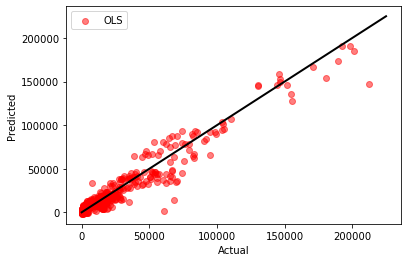

In [18]:
#How closely to the y=x line do the OLS predictions run?
plt.scatter(y_test, y_predict_ols, alpha=0.5, c='r', label='OLS')
plt.plot([0, 225000], [0, 225000], color='k', linestyle='-', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.show()

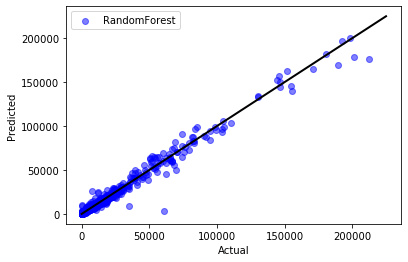

In [19]:
#How closely to the y=x line do the random forest predictions run?
plt.scatter(y_test, y_predict_rf, alpha=0.5, c='b', label='RandomForest')
plt.plot([0, 225000], [0, 225000], color='k', linestyle='-', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.show()